<a href="https://www.kaggle.com/code/cheesegue/eda-llm-detect?scriptVersionId=156921236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **LLM - AI 生成テキストの検出**
どのエッセイが大規模な言語モデルによって書かれたのかを特定する  
LLM - Detect AI Generated Text  </br>(https://www.kaggle.com/competitions/llm-detect-ai-generated-text)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# 参考資料
**書籍**

**Kaggle**
- [AI or Not AI? Delving Into Essays with EDA](https://www.kaggle.com/code/pamin2222/ai-or-not-ai-delving-into-essays-with-eda/notebook)

**記事**

**自分で作成したファイル**
- モース硬度データセットを使用した回帰
- 生体信号を使用した喫煙者の状態のバイナリ予測
- ソフトウェア欠陥データセットによるバイナリ分類
- 肝硬変の転帰の多クラス予測
- 馬の健康への影響を予測する
- [👣EDA_Titanic_日本語向け](https://www.kaggle.com/code/cheesegue/eda-titanic/comments#2577168)

# ライブラリ・データセットのインポート

In [2]:
!pip install sweetviz
!pip install category_encoders

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 52.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display, Markdown
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder, Normalizer
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [5]:
from collections import Counter
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import re

## 実行時間を調べるために使う

In [6]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [7]:
FILE_PATH = '/kaggle/input/llm-detect-ai-generated-text/'
OUTPUT_DIR = '/kaggle/working/'

train_essays = pd.read_csv(FILE_PATH + 'train_essays.csv')
test = pd.read_csv(FILE_PATH + 'test_essays.csv')
train_prompts = pd.read_csv(FILE_PATH + 'train_prompts.csv')

In [8]:
target = train_essays['generated']
target_col = 'generated'
target_name = str(train_essays.iloc[:, [3]].columns.tolist())
print(target_name)

['generated']


## データ(DataFrame)の構成を調べる

In [9]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [10]:
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [11]:
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [12]:
print('train_essays: ')
print(train_essays.shape)
print(train_essays.info())
print('\n')
print('train_prompts: ')
print(train_prompts.shape)
print(train_prompts.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train_essays: 
(1378, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


train_prompts: 
(2, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


test: 
(3, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null C

In [13]:
train_essays_columns = train_essays.columns
train_essays_index = train_essays.index
train_essays_data = train_essays.values # values

train_prompts_columns = train_prompts.columns
train_prompts_index = train_prompts.index
train_prompts_data = train_prompts.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_essays_columns))
print(type(train_essays_index))
print(type(train_essays_data))
print('\n')
print('train: ')
print(type(train_prompts_columns))
print(type(train_prompts_index))
print(type(train_prompts_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [14]:
with pd.option_context('display.max_rows', 8):
    display(train_essays)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
...,...,...,...,...
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0
1377,ffe1ca0d,0,Cars have been around since the 1800's and hav...,0


In [15]:
with pd.option_context('display.max_rows', 8):
    display(test)

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [16]:
with pd.option_context('display.max_rows', 8):
    display(train_prompts)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [17]:
print('train_essays: ')
print(train_essays.dtypes)
print(train_essays.dtypes.value_counts())
print('\n')
print('train_prompts: ')
print(train_prompts.dtypes)
print(train_prompts.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train_essays: 
id           object
prompt_id     int64
text         object
generated     int64
dtype: object
object    2
int64     2
Name: count, dtype: int64


train_prompts: 
prompt_id        int64
prompt_name     object
instructions    object
source_text     object
dtype: object
object    3
int64     1
Name: count, dtype: int64


test: 
id           object
prompt_id     int64
text         object
dtype: object
object    2
int64     1
Name: count, dtype: int64


In [18]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['prompt_id'], dtype='object'), Index(['id', 'text'], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 欠損値

In [19]:
print('train: ')
print(train_essays.isna().sum().any())
print(train_essays.isnull().sum())
print('\n')
print('train: ')
print(train_prompts.isna().sum().any())
print(train_prompts.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
id           0
prompt_id    0
text         0
generated    0
dtype: int64


train: 
False
prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


test: 
False
id           0
prompt_id    0
text         0
dtype: int64


Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


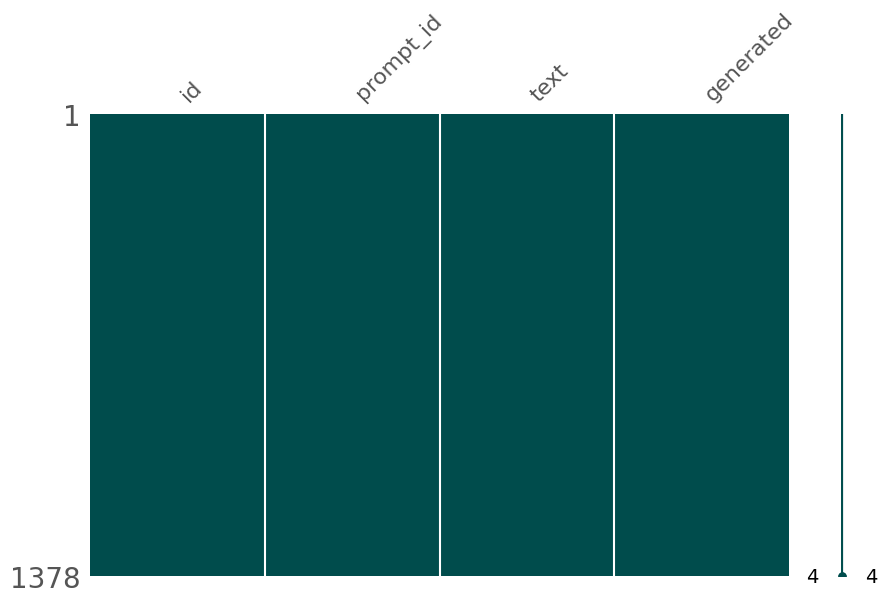

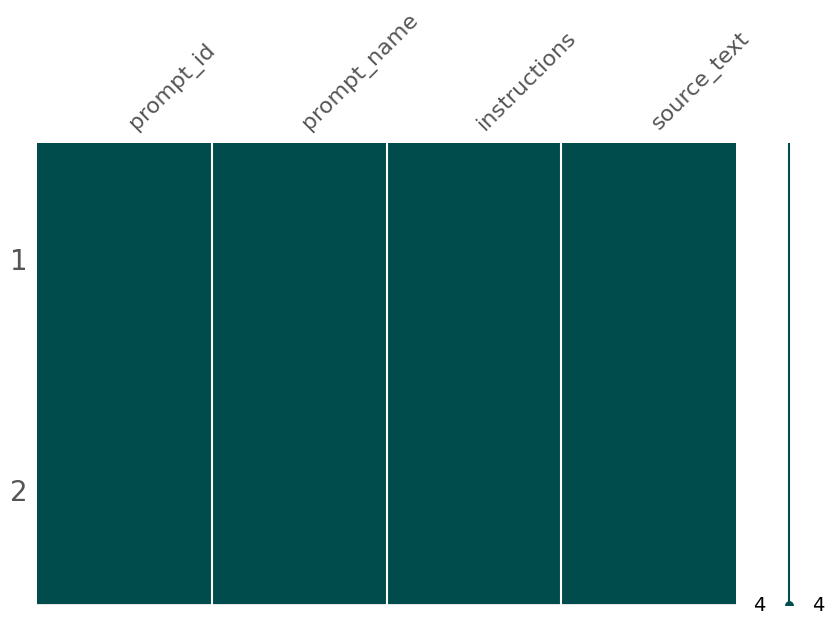

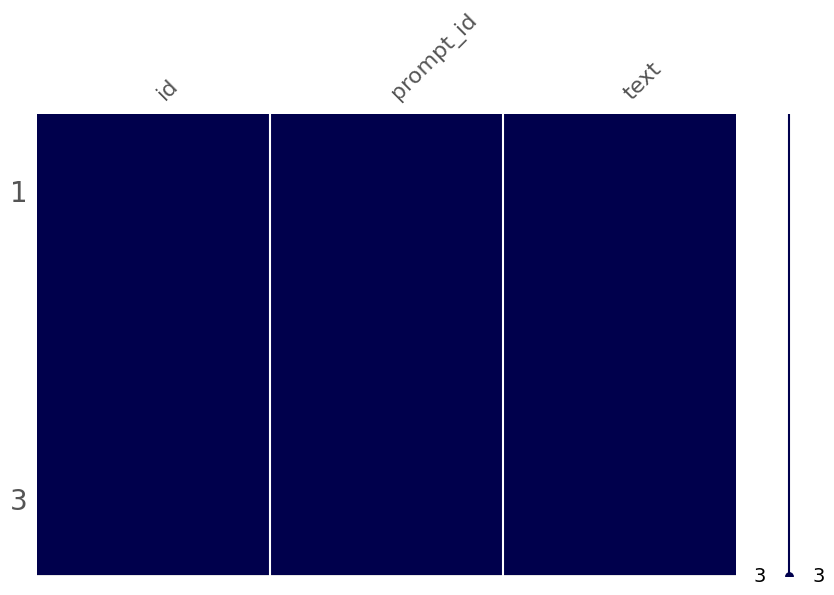

In [20]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train_essays, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=train_prompts, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

## カラムごとのユニークな値を調べる

In [21]:
train_essays[train_essays.columns].nunique().sort_values(ascending=True)

prompt_id       2
generated       2
id           1378
text         1378
dtype: int64

In [22]:
train_prompts[train_prompts.columns].nunique().sort_values(ascending=True)

prompt_id       2
prompt_name     2
instructions    2
source_text     2
dtype: int64

### 目的変数

In [23]:
print(target_name +' Class labels:', np.unique(target))

['generated'] Class labels: [0 1]


### 円グラフと棒グラフ（目的変数）

generated
0    1375
1       3
Name: count, dtype: int64


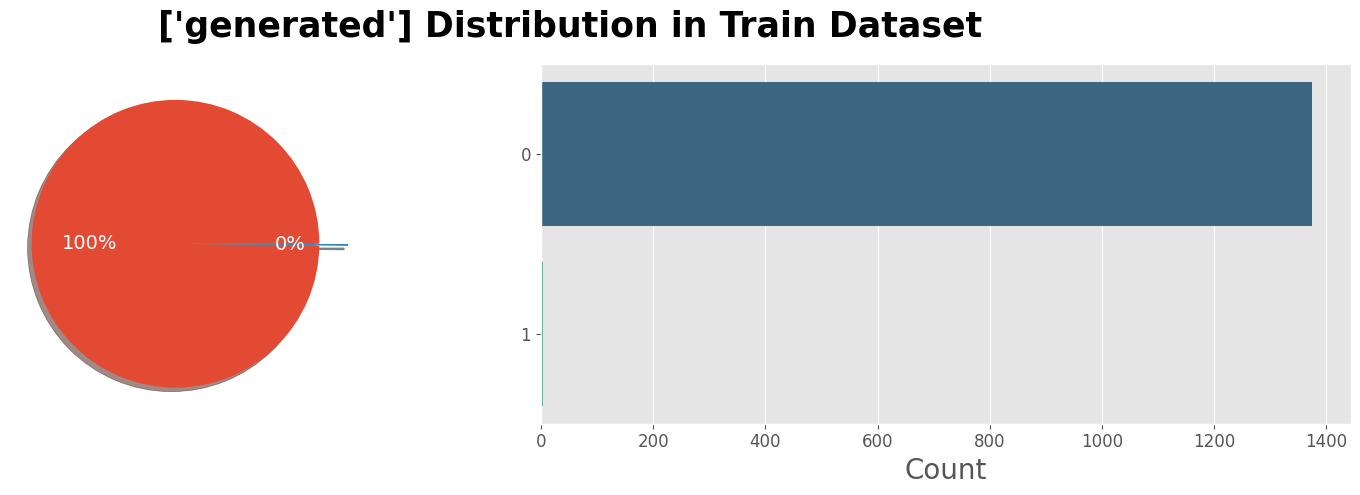

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train_essays, y=target_col, ax=ax[1], palette='viridis', order=train_essays[target_col].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train_essays[target_col].value_counts()}')

In [25]:
llm_generated_counts = train_essays[train_essays['generated'] == 1]['prompt_id'].value_counts()
llm_generated_counts

prompt_id
1    2
0    1
Name: count, dtype: int64

## データセットのプロット（分布）

### 密度関数（ヒストグラム）

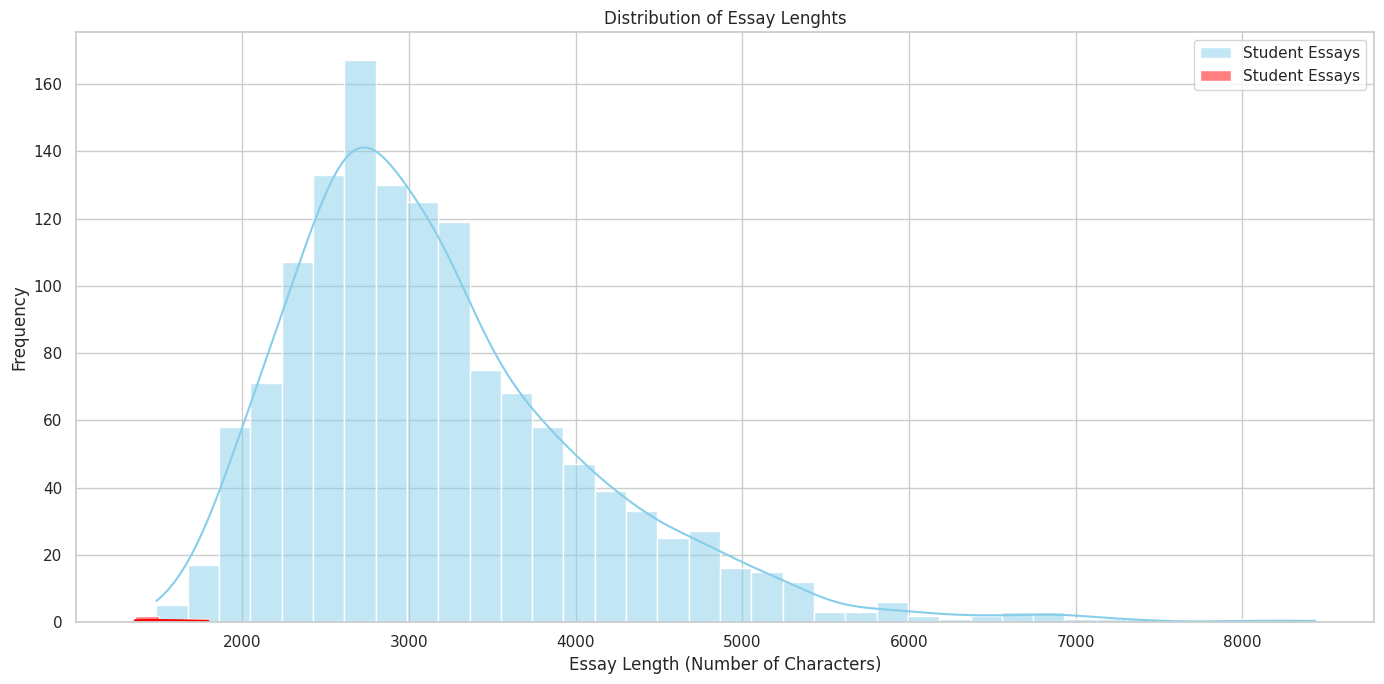

In [26]:
# エッセイの文字数の長さに関するカラムを作成する
train_essays['essay_length'] = train_essays['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.histplot(train_essays[train_essays['generated']==0]['essay_length'], color='skyblue', label='Student Essays', kde=True)
sns.histplot(train_essays[train_essays['generated']==1]['essay_length'], color='red',label='Student Essays', kde=True)

plt.title('Distribution of Essay Lenghts')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()

plt.show()

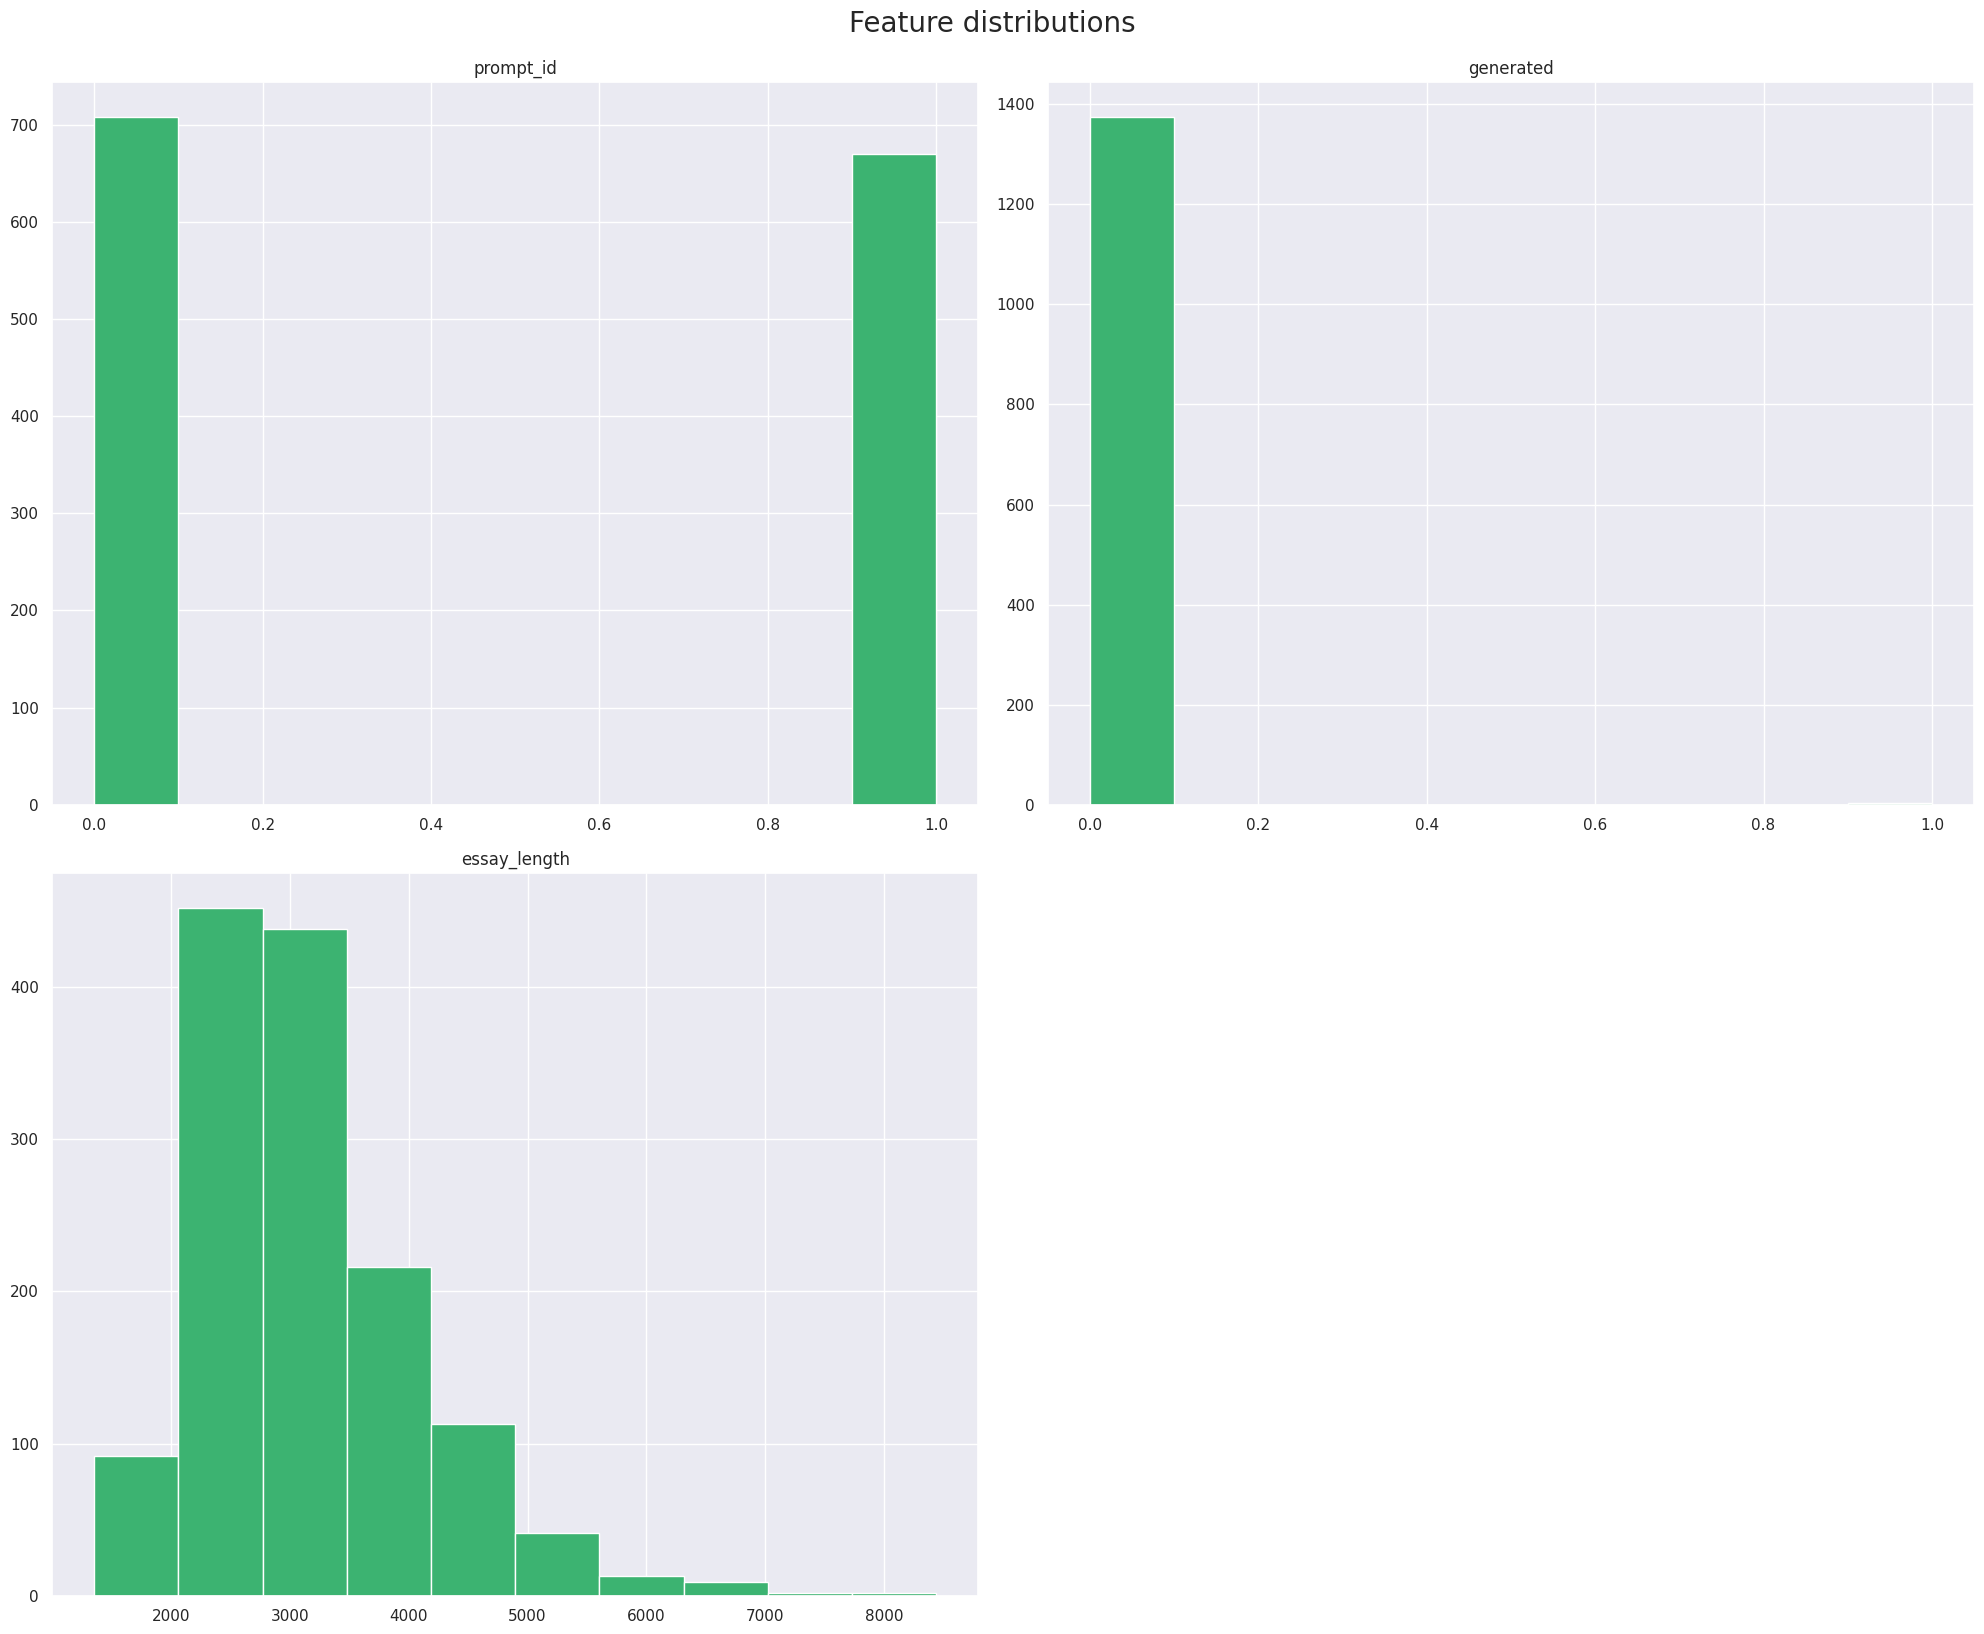

In [27]:
sns.set(rc={'figure.figsize': (20, 16)})
train_essays.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

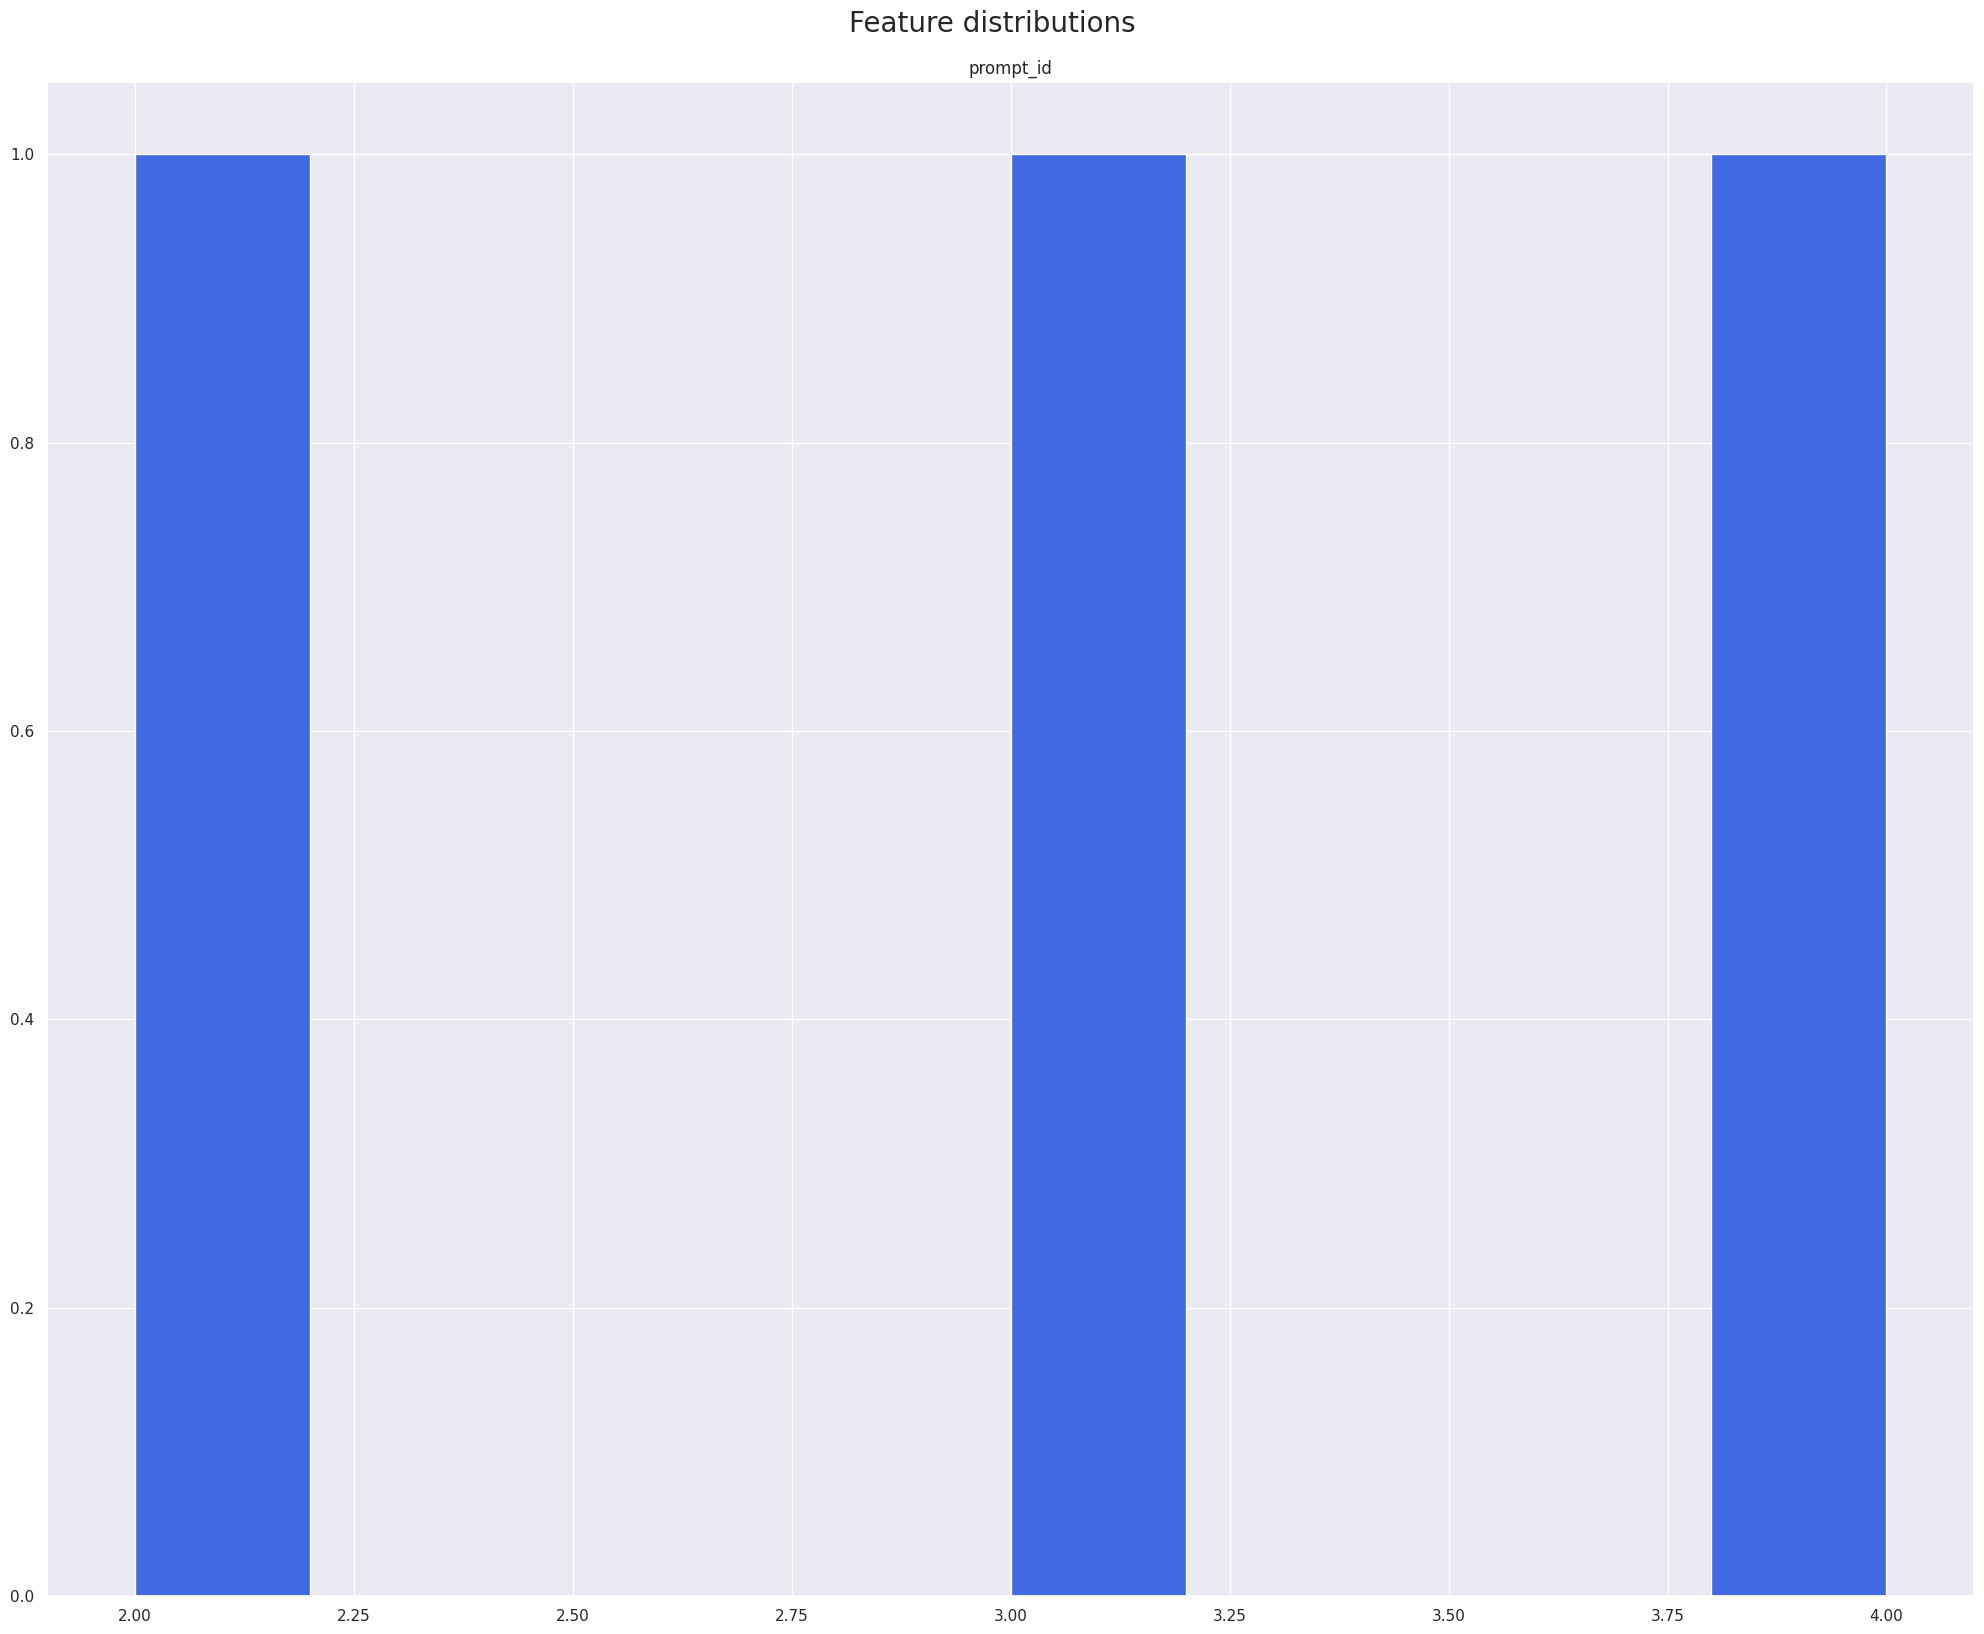

In [28]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

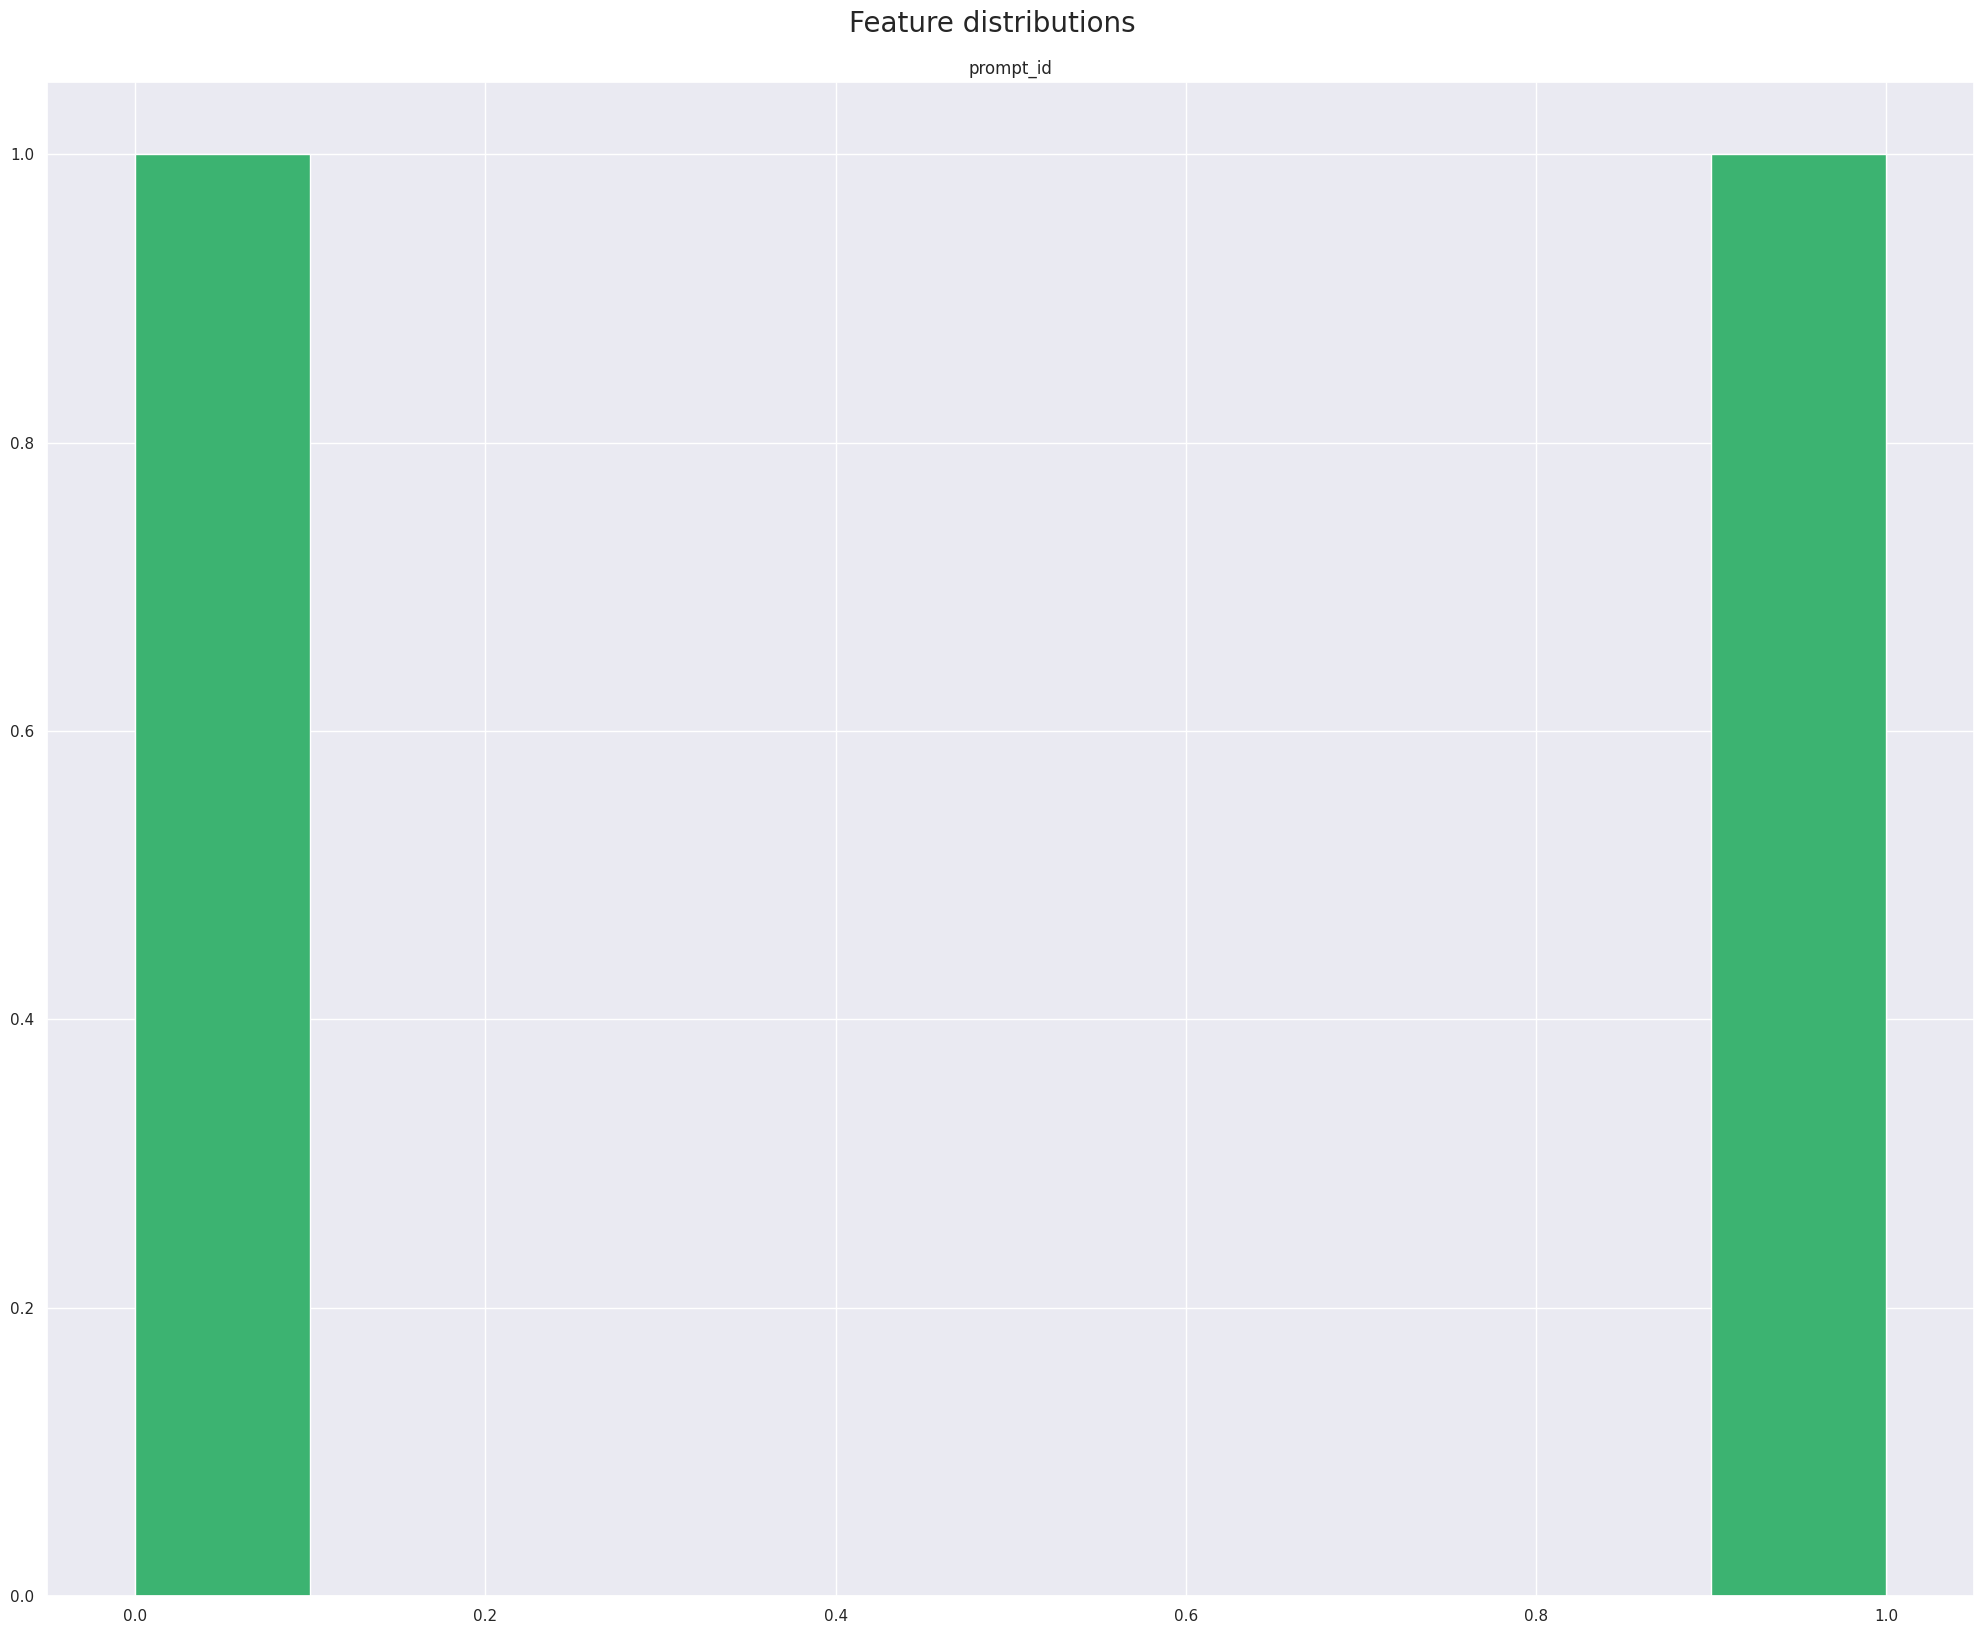

In [29]:
sns.set(rc={'figure.figsize': (20, 16)})
train_prompts.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

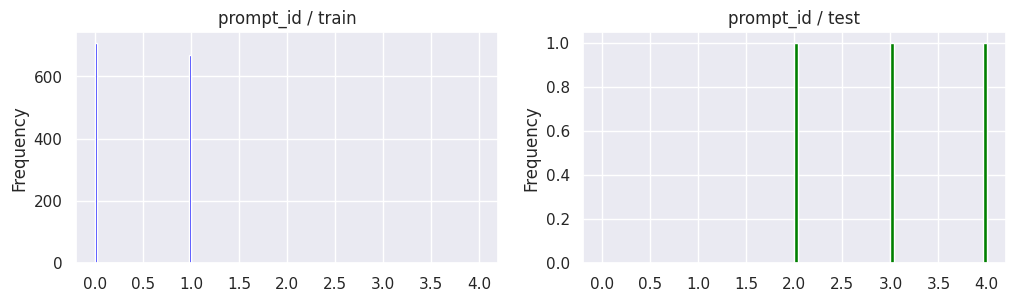

In [30]:
feature = train_essays[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train_essays[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

### 箱ひげ図

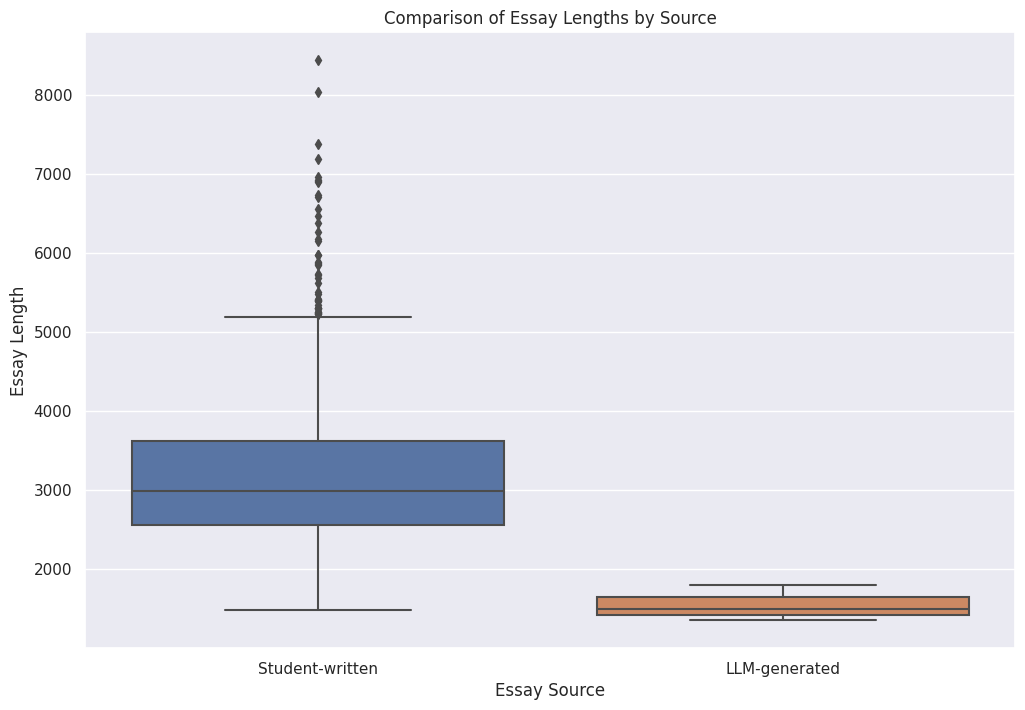

In [31]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=train_essays)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()

エッセイの長さは生徒によって大幅に異なり、通常は利用可能な数少ないLLM生成のエッセイよりも長いです。

In [32]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    
    return word_count, unique_word_count, sentence_count, avg_word_length

train_essays['metrics'] = train_essays['text'].apply(calculate_text_metrics_simple)

train_essays[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train_essays['metrics'].tolist(), index=train_essays.index)
train_essays.drop('metrics', axis=1, inplace=True)

comparison_metrics = train_essays.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()
comparison_metrics

,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.76873,275.33455,30.06327,4.69487
1,260.66667,146.33333,13.00000,4.93561


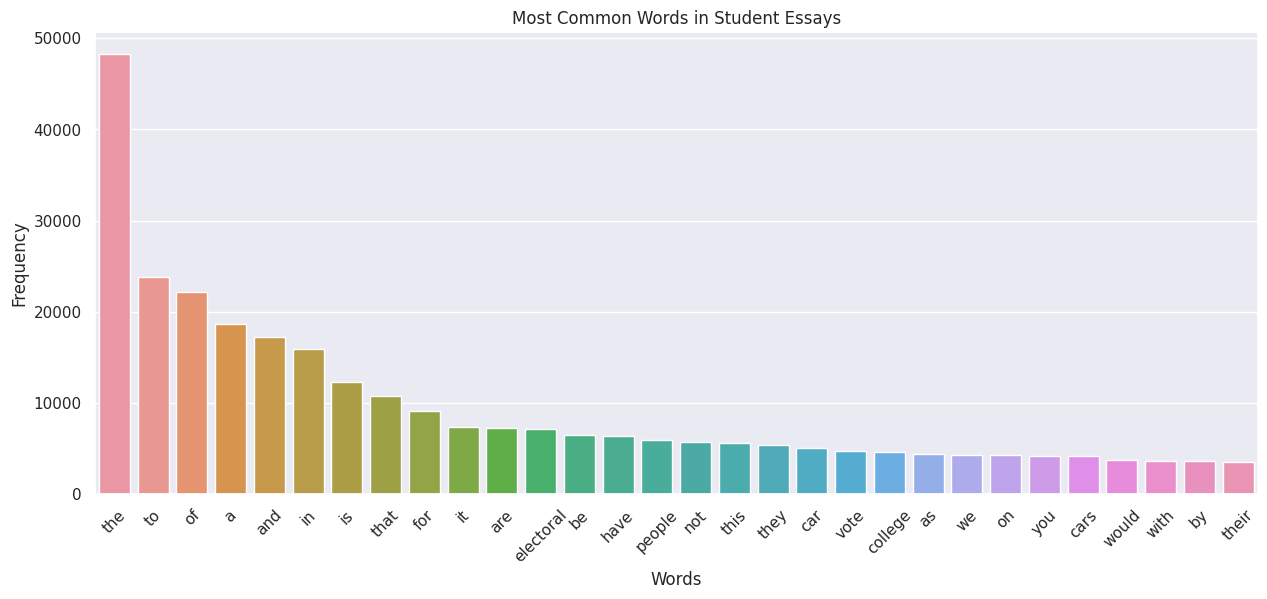

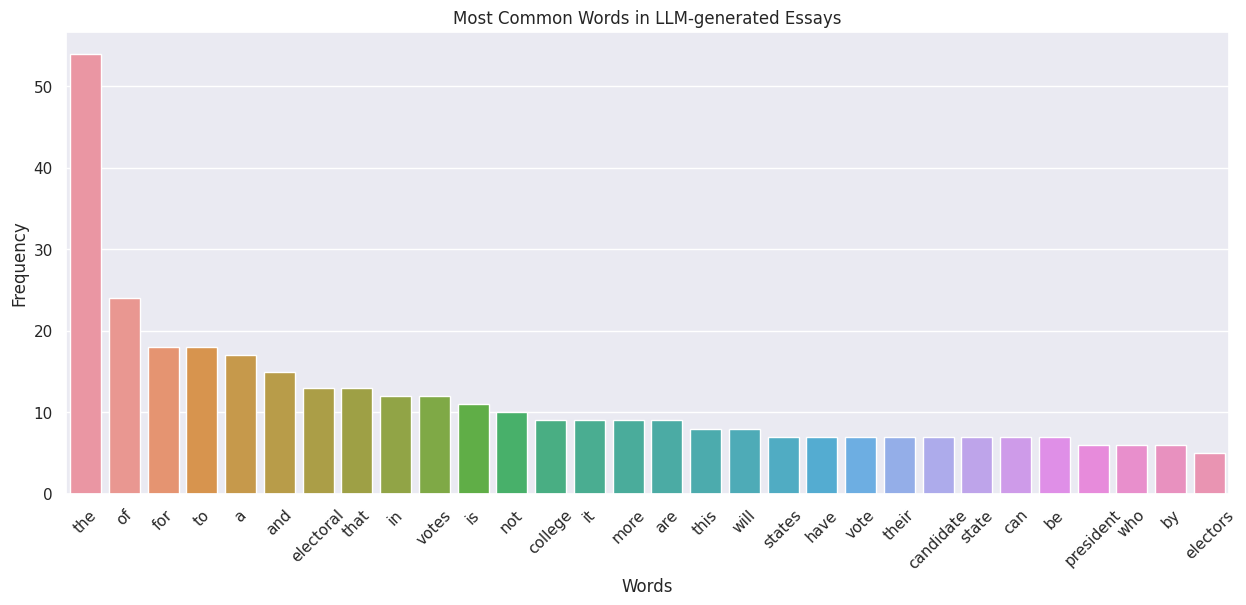

In [33]:
# 共通している用語を調べる
def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()
    
plot_most_common_words(train_essays[train_essays['generated']==0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train_essays[train_essays['generated']==1]['text'], title="Most Common Words in LLM-generated Essays")

In [34]:
# プロンプトとエッセイの関係
train_prompts_ex = train_prompts.iloc[0]
print(train_prompts.columns)

Index(['prompt_id', 'prompt_name', 'instructions', 'source_text'], dtype='object')


In [35]:
# カラムごとの要素を表示する
display(Markdown(f"### Prompt Name:\n{train_prompts_ex['prompt_name']}"))
display(Markdown("="* 50))
display(Markdown(f"### Instructions:\n{train_prompts_ex['instructions']}"))
display(Markdown("="* 50))
display(Markdown(f"### Source Text:\n (The text of the article(s) the essays were written in response to)"))

### Prompt Name:
Car-free cities

==================================================

### Instructions:
Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.

==================================================

### Source Text:
 (The text of the article(s) the essays were written in response to)

### Prompt Usage Frequency

prompt_id
0    708
1    670
Name: count, dtype: int64

### Average Essay Length by Prompt

prompt_id
0   3251.92797
1   3081.47313
Name: essay_length, dtype: float64

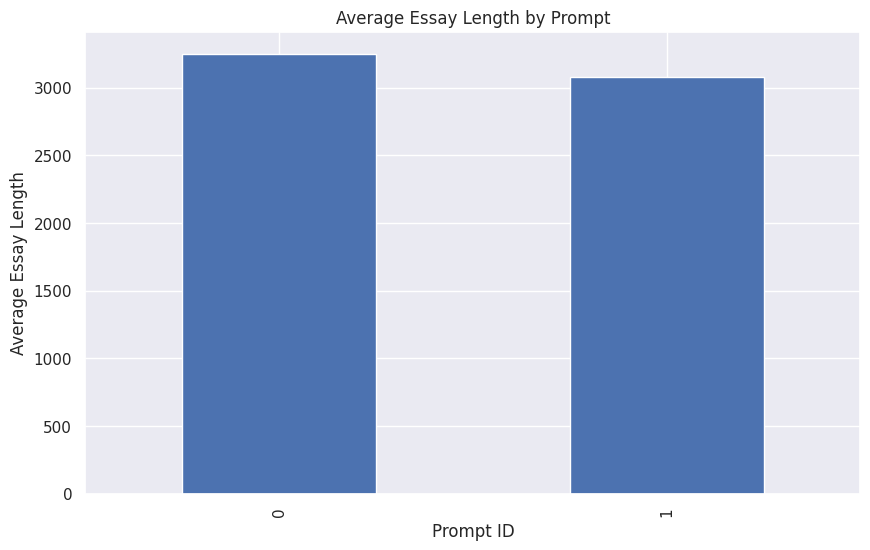

In [36]:
merged_df = train_essays.merge(train_prompts, on='prompt_id', how='left')

prompt_usage = merged_df['prompt_id'].value_counts()
avg_length_by_prompt = merged_df.groupby('prompt_id')['essay_length'].mean()

display(Markdown('### Prompt Usage Frequency'))
display(prompt_usage)

display(Markdown("### Average Essay Length by Prompt"))
display(avg_length_by_prompt)

plt.figure(figsize=(10, 6))
avg_length_by_prompt.plot(kind='bar')
plt.title('Average Essay Length by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Average Essay Length')
plt.show()


top_words: [('electoral', 44), ('vote', 36), ('electors', 31), ('car', 28), ('college', 27), ('president', 25), ('state', 23), ('election', 21), ('votes', 20), ('cars', 19)]


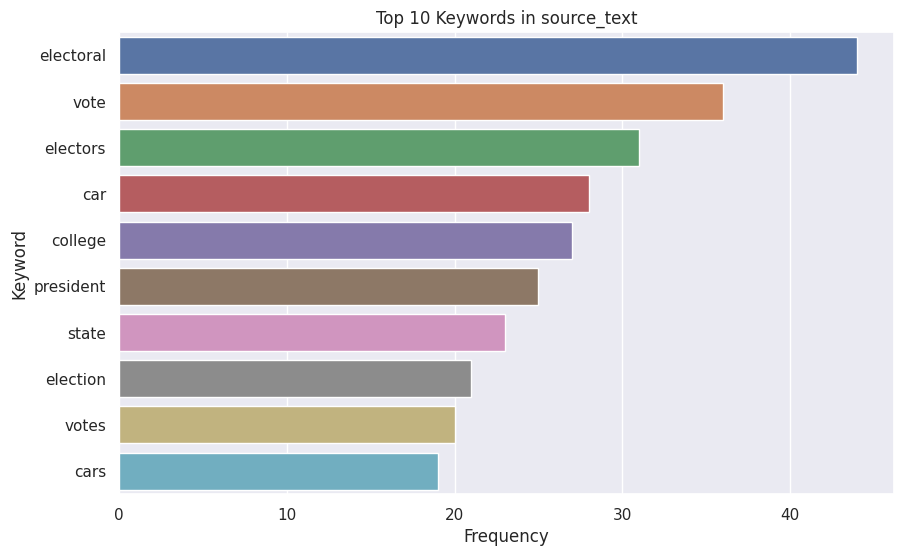


top_words: [('electoral', 7234), ('people', 6924), ('college', 6081), ('vote', 6000), ('car', 5888), ('cars', 5731), ('states', 4132), ('president', 3615), ('votes', 2536), ('electors', 2515)]


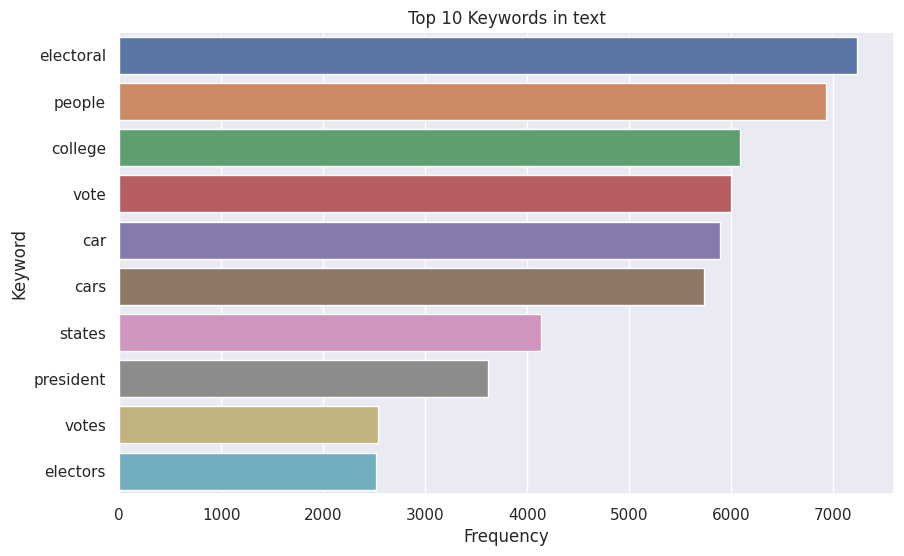

In [37]:
def plot_top_keywords(data, column, num_keywords=10):
    vec = CountVectorizer(stop_words='english').fit(data[column])
    bag_of_words = vec.transform(data[column])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words = words_freq[:num_keywords]
    print("\ntop_words:", top_words)
    top_df = pd.DataFrame(top_words, columns=['Keyword', 'Frequency'])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Keyword', data=top_df)
    plt.title(f'Top {num_keywords} Keywords in {column}')
    plt.show()
    
plot_top_keywords(train_prompts, 'source_text')
plot_top_keywords(train_essays, 'text')

In [38]:
# テーマ分析：　キーワード
def get_top_n_grams(corpus, n=None, n_grams=2):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

top_bigrams_prompts = get_top_n_grams(train_prompts['source_text'], n=10, n_grams=2)
top_bigrams_essays = get_top_n_grams(train_essays['text'], n=10, n_grams=2)

print("Top 10 Bigrams in Prompts:")
for bigram, freq in top_bigrams_prompts:
    print(f"{bigram}: {freq}")

print("\nTop 10 Bigrams in Essays:")
for bigram, freq in top_bigrams_essays:
    print(f"{bigram}: {freq}")

Top 10 Bigrams in Prompts:
electoral college: 27
electoral votes: 11
popular vote: 9
new york: 8
united states: 7
york times: 6
times company: 6
car free: 5
electoral vote: 5
elisabeth rosenthal: 4

Top 10 Bigrams in Essays:
electoral college: 5794
car usage: 1998
popular vote: 1737
united states: 1179
limiting car: 1158
electoral votes: 689
vote president: 676
air pollution: 535
use cars: 518
greenhouse gas: 448


In [39]:
# テーマの一貫性を分析する
def calculate_thematic_coherence(essays, prompts):
    vectorizer = TfidfVectorizer(stop_words='english')
    dtm = vectorizer.fit_transform(essays + prompts)
    
    lsa = TruncatedSVD(n_components=1)
    dtm_lsa = lsa.fit_transform(dtm)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    
    essay_vectors = dtm_lsa[:len(essays)]
    prompt_vectors = dtm_lsa[len(essays):]
    
    coherence_scores = cosine_similarity(essay_vectors, prompt_vectors)
    
    return coherence_scores.mean()

coherence_score = calculate_thematic_coherence(
    list(train_essays['text']),
    list(train_prompts['source_text']))

print(f"Thematic Coherence Score: {coherence_score}")

Thematic Coherence Score: 1.0


In [40]:
# 文字と単語数を調べる
numeral_pattern = re.compile(r'\b\d+\b')
word_number_pattern = re.compile(
    r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', re.IGNORECASE)

def count_digit_styles(text, numeral_regex, word_number_regex):
    numeral_matches = len(re.findall(numeral_regex, text))
    word_number_matches = len(re.findall(word_number_regex, text))
    
    return numeral_matches, word_number_matches

train_essays_df = train_essays.copy()
train_essays_df[['numerals', 'number_words']] = train_essays_df['text'].apply(
    lambda x: count_digit_styles(x, numeral_pattern, word_number_pattern)).apply(pd.Series)

student_essays = train_essays_df[train_essays_df['generated']==0]
llm_essays = train_essays_df[train_essays_df['generated']==1]

student_numerals = student_essays['numerals'].sum()
student_number_words = student_essays['number_words'].sum()
llm_numerals = llm_essays['numerals'].sum()
llm_number_words = llm_essays['number_words'].sum()

print(f"Student Essays - Numerals: {student_numerals}, Number Words: {student_number_words}")
print(f"LLM Essays - Numerals: {llm_numerals}, Number Words: {llm_number_words}")

avg_student_numerals = student_numerals / len(student_essays)
avg_student_number_words = student_number_words / len(student_essays)
avg_llm_numerals = llm_numerals / len(llm_essays) if len(llm_essays) > 0 else 0
avg_llm_number_words = llm_number_words / len(llm_essays) if len(llm_essays) > 0 else 0

print()
print(f"Average Numerals per Student Essay: {avg_student_numerals:.2f}")
print(f"Average Number Words per Student Essay: {avg_student_number_words:.2f}")
print()
print(f"Average Numerals per LLM Essay: {avg_llm_numerals:.2f}")
print(f"Average Number Words per LLM Essay: {avg_llm_number_words:.2f}")

Student Essays - Numerals: 7757, Number Words: 3747
LLM Essays - Numerals: 3, Number Words: 6

Average Numerals per Student Essay: 5.64
Average Number Words per Student Essay: 2.73

Average Numerals per LLM Essay: 1.00
Average Number Words per LLM Essay: 2.00
